In [27]:
import numpy as np
import torch_geometric
print(torch_geometric.__version__)

def calculate_force(particle1, particle2):
    dx = particle2[0] - particle1[0]
    dy = particle2[1] - particle1[1]
    r_squared = dx**2 + dy**2
    
    if r_squared == 0:
        return [0, 0]  # Avoid division by zero
    
    force_magnitude = particle1[2] * particle2[2] / r_squared
    force_x = force_magnitude * dx / np.sqrt(r_squared)
    force_y = force_magnitude * dy / np.sqrt(r_squared)
    
    return [force_x, force_y]

def generate_particle_dataset(num_points):
    dataset = []
    min_distance = 0.1  # Minimum distance constraint
    
    for _ in range(num_points):
        data_point = []
        positions = []

        # Generate 3 particles with unique positions separated by at least 0.1
        for _ in range(3):
            while True:
                x = np.random.uniform(0, 1)
                y = np.random.uniform(0, 1)
                position = (x, y)

                # Check distance against all existing particles
                if all(np.sqrt((x - px)**2 + (y - py)**2) >= min_distance for px, py in positions):
                    positions.append(position)
                    break
            
            mass = np.random.uniform(0.1, 1)
            particle = [x, y, mass, [0, 0]]  # [x, y, mass, [force_x, force_y]]
            data_point.append(particle)
        
        # Calculate forces
        for i in range(3):
            for j in range(3):
                if i != j:
                    force = calculate_force(data_point[i], data_point[j])
                    data_point[i][3][0] += force[0]
                    data_point[i][3][1] += force[1]
        
        dataset.append(data_point)
    
    return dataset

# Generate a dataset with 100 data points
num_points = 1000
particle_dataset = generate_particle_dataset(num_points)

# Print the first few data points as an example
for i, data_point in enumerate(particle_dataset[:3]):
    print(f"Data point {i + 1}:")
    for j, particle in enumerate(data_point):
        print(f"  Particle {j + 1}: [x = {particle[0]:.6f}, y = {particle[1]:.6f}, mass = {particle[2]:.4f}, force = [{particle[3][0]:.6e}, {particle[3][1]:.6e}]]")
    print()

2.5.3
Data point 1:
  Particle 1: [x = 0.616116, y = 0.509666, mass = 0.6633, force = [-1.293101e+00, -1.012959e+00]]
  Particle 2: [x = 0.983309, y = 0.032537, mass = 0.6512, force = [-1.206917e+00, 1.192259e+00]]
  Particle 3: [x = 0.093937, y = 0.491891, mass = 0.8318, force = [2.500018e+00, -1.793006e-01]]

Data point 2:
  Particle 1: [x = 0.598537, y = 0.769878, mass = 0.4704, force = [-4.930512e-01, -1.499612e+00]]
  Particle 2: [x = 0.743849, y = 0.261461, mass = 0.7518, force = [-6.981232e-01, 1.506038e+00]]
  Particle 3: [x = 0.265089, y = 0.657426, mass = 0.2336, force = [1.191174e+00, -6.426409e-03]]

Data point 3:
  Particle 1: [x = 0.580083, y = 0.440711, mass = 0.3088, force = [2.242243e+00, -2.165945e+00]]
  Particle 2: [x = 0.901498, y = 0.220005, mass = 0.3076, force = [-1.231559e+01, 1.947655e+00]]
  Particle 3: [x = 0.774013, y = 0.237225, mass = 0.6406, force = [1.007334e+01, 2.182894e-01]]



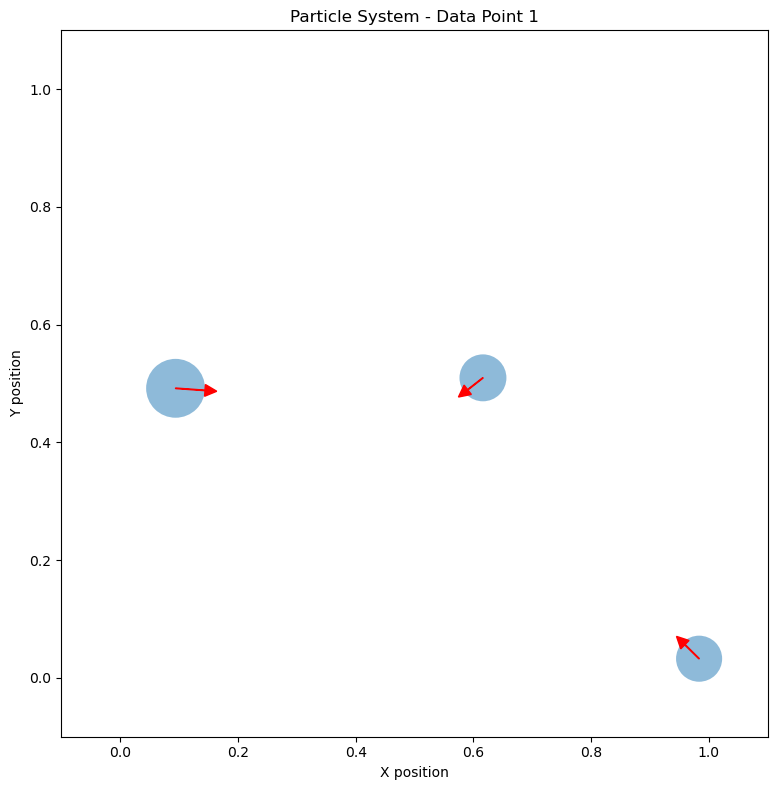

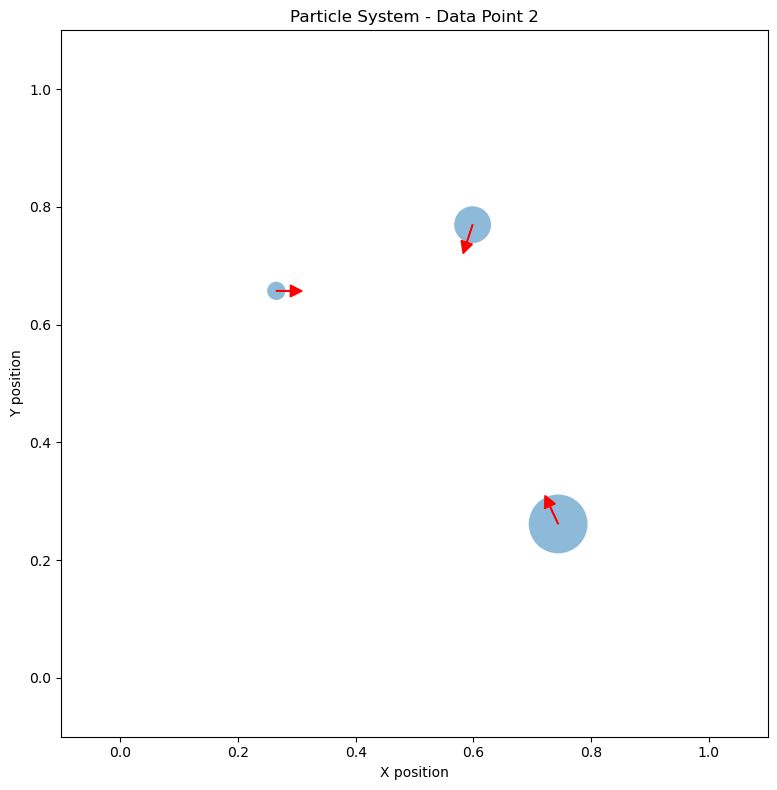

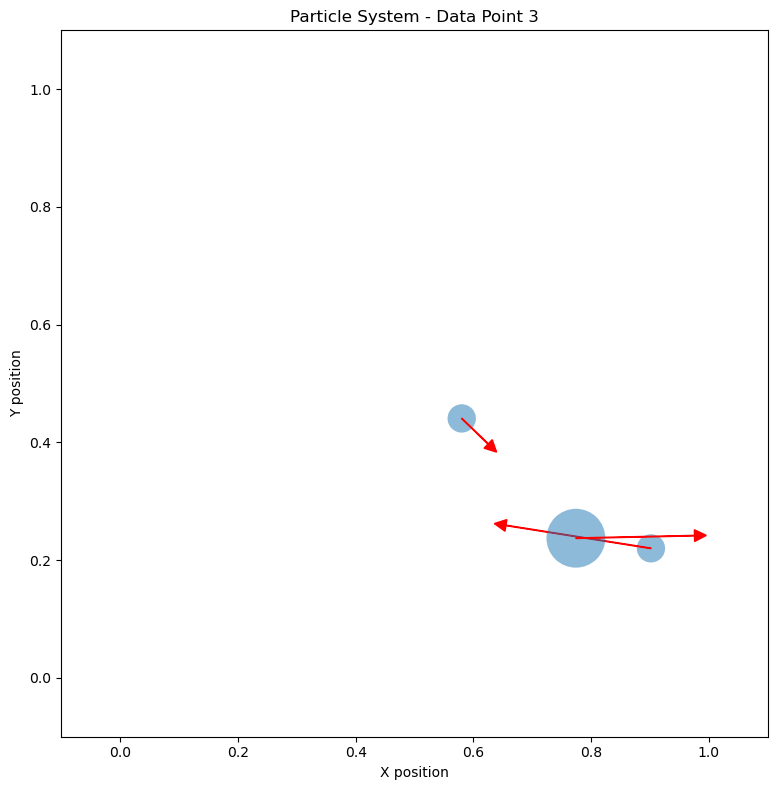

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def plot_particle_system(data_point, index):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Set plot limits
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    
    # Find the maximum mass for scaling
    max_mass = max(particle[2] for particle in data_point)
    
    # Plot particles and forces
    for particle in data_point:
        x, y, mass, force = particle
        
        # Plot particle as a circle
        radius = (mass / max_mass) / 20  # Scale size relative to maximum mass
        circle = plt.Circle((x, y), radius=radius, fill=True, alpha=0.5)
        ax.add_artist(circle)
        
        # Plot force arrow
        force_x, force_y = force
        # Scale arrow length
        scale = 0.02
        ax.arrow(x, y, force_x * scale, force_y * scale, 
                    head_width=0.02, head_length=0.02, fc='r', ec='r')
    
    ax.set_aspect('equal')
    ax.set_title(f'Particle System - Data Point {index}')
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    
    plt.tight_layout()
    plt.show()

# Assuming particle_dataset is already generated
# Plot the first 3 data points
for i, data_point in enumerate(particle_dataset[:3]):
    plot_particle_system(data_point, i+1)

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data

class EdgeModel(MessagePassing):
    def __init__(self):
        super(EdgeModel, self).__init__(aggr='add')  # "Add" aggregation.
        self.mlp = nn.Sequential(
            nn.Linear(6, 128),  # 6 = 2 (pos) + 1 (mass) for each particle
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2)  # Output 2D force
        )

    def forward(self, x, edge_index):
        # print("edge index: ", edge_index)
        return self.propagate(edge_index, x=x)

    def message(self, x_i, x_j):
        tmp = torch.cat([x_i, x_j], dim=1)  # Concatenate features of both nodes
        # print(tmp)
        out = self.mlp(tmp)
        # print("out: ", out)
        return out

class NodeModel(nn.Module):
    def __init__(self):
        super(NodeModel, self).__init__()
        self.mlp = nn.Sequential(
            # nn.Linear(5, 32),  # 5 = 2 (pos) + 1 (mass) + 2 (aggregated force)
            # nn.ReLU(),
            # nn.Linear(32, 5),
            # nn.ReLU(),
            nn.Linear(5, 2)  # Output 2D force
        )

    def forward(self, x, edge_index, edge_attr):
        # The edge attributes have already been added when the Message Passing layer was
        # applied. Simply concatenate them with the node's features.
        # print("edge attributes: ", edge_attr)
        out = torch.cat([x, edge_attr], dim=1)
        return self.mlp(out)

class ParticleGNN(nn.Module):
    def __init__(self):
        super(ParticleGNN, self).__init__()
        self.edge_model = EdgeModel()
        self.node_model = NodeModel()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # Edge Model
        edge_attr = self.edge_model(x, edge_index)
        
        # Node Model
        out = self.node_model(x, edge_index, edge_attr)
        
        return out

# Create a sample input
def create_sample_data(num_particles=3):
    x = torch.rand(num_particles, 3)  # [x, y, mass] for each particle
    edge_index = torch.tensor([[0, 0, 1, 1, 2, 2],
                               [1, 2, 0, 2, 0, 1]], dtype=torch.long)
    data = Data(x=x, edge_index=edge_index)
    return data

# Initialize the model
model = ParticleGNN()

# Create sample data
data = create_sample_data()
print(data)
print("node info: ", data.x)

# Forward pass
output = model(data)

print("Input:")
print(data.x)
print("\nOutput (forces):")
print(output)


Data(x=[3, 3], edge_index=[2, 6])
node info:  tensor([[0.4748, 0.0339, 0.2506],
        [0.5687, 0.3762, 0.3856],
        [0.2099, 0.4798, 0.6898]])
Input:
tensor([[0.4748, 0.0339, 0.2506],
        [0.5687, 0.3762, 0.3856],
        [0.2099, 0.4798, 0.6898]])

Output (forces):
tensor([[-0.1018,  0.4018],
        [-0.0137,  0.3934],
        [-0.1021,  0.2955]], grad_fn=<AddmmBackward0>)


In [30]:
x_dataset = []
y_dataset = []
edge_index = torch.tensor([[0, 0, 1, 1, 2, 2],
                           [1, 2, 0, 2, 0, 1]], dtype=torch.long)
for data_point in particle_dataset:
    x = torch.tensor([particle[:3] for particle in data_point], dtype=torch.float32)
    y = torch.tensor([particle[3] for particle in data_point], dtype=torch.float32)
    x_dataset.append(Data(x=x, edge_index=edge_index))
    y_dataset.append(y)


for particle in particle_dataset[:2]:
    print(particle)

print("\n")

for x in x_dataset[:2]:
    print(x.x)

print("\n")

for y in y_dataset[:2]:
    print(y)

[[0.6161157574842869, 0.5096662080339309, 0.6632538980952803, [-1.293101442043127, -1.012958533595781]], [0.9833091568684578, 0.03253713357674759, 0.6511520209952707, [-1.2069166081207372, 1.1922591541375336]], [0.09393729915598126, 0.4918909800469652, 0.8317838195277933, [2.500018050163864, -0.17930062054175283]]]
[[0.5985373215165358, 0.7698777959571205, 0.470381149667334, [-0.49305117431862533, -1.4996117198591161]], [0.7438491608160699, 0.2614609632802898, 0.7518289108227931, [-0.6981231812922868, 1.506038128767424]], [0.2650891466535299, 0.6574261375142406, 0.23355165413979576, [1.191174355610912, -0.006426408908307868]]]


tensor([[0.6161, 0.5097, 0.6633],
        [0.9833, 0.0325, 0.6512],
        [0.0939, 0.4919, 0.8318]])
tensor([[0.5985, 0.7699, 0.4704],
        [0.7438, 0.2615, 0.7518],
        [0.2651, 0.6574, 0.2336]])


tensor([[-1.2931, -1.0130],
        [-1.2069,  1.1923],
        [ 2.5000, -0.1793]])
tensor([[-0.4931, -1.4996],
        [-0.6981,  1.5060],
        [ 1.19

Using device: cuda
Epoch [1/200], Loss: 29.9465, Learning Rate: 0.0190000000
Epoch [2/200], Loss: 27.7808, Learning Rate: 0.0180500000
Epoch [3/200], Loss: 26.5256, Learning Rate: 0.0171475000
Epoch [4/200], Loss: 21.9439, Learning Rate: 0.0162901250
Epoch [5/200], Loss: 17.6608, Learning Rate: 0.0154756187
Epoch [6/200], Loss: 14.6198, Learning Rate: 0.0147018378
Epoch [7/200], Loss: 13.4653, Learning Rate: 0.0139667459
Epoch [8/200], Loss: 8.0395, Learning Rate: 0.0132684086
Epoch [9/200], Loss: 6.5834, Learning Rate: 0.0126049882
Epoch [10/200], Loss: 6.8875, Learning Rate: 0.0119747388
Epoch [11/200], Loss: 4.5271, Learning Rate: 0.0113760018
Epoch [12/200], Loss: 3.6666, Learning Rate: 0.0108072018
Epoch [13/200], Loss: 3.2647, Learning Rate: 0.0102668417
Epoch [14/200], Loss: 2.2991, Learning Rate: 0.0097534996
Epoch [15/200], Loss: 1.5897, Learning Rate: 0.0092658246
Epoch [16/200], Loss: 1.4228, Learning Rate: 0.0088025334
Epoch [17/200], Loss: 0.8965, Learning Rate: 0.00836240

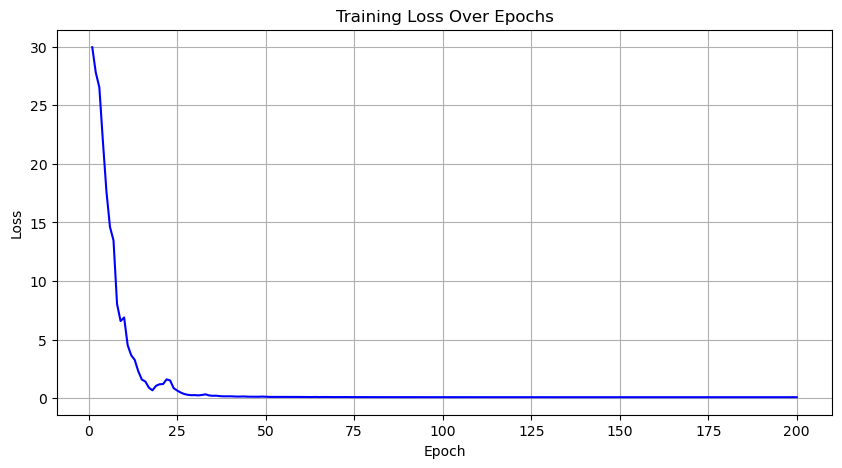

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch_geometric.loader import DataLoader
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the device
model = model.to(device)

# Create a custom dataset that combines x (graph data) and y (labels)
class GraphDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data  # List of torch_geometric.data.Data objects
        self.y_data = y_data  # Corresponding labels

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]  # Get the graph data
        y = self.y_data[idx]  # Get the corresponding label
        x.y = y  # Assign the label to the graph data object
        return x

# Initialize the custom dataset
dataset = GraphDataset(x_dataset, y_dataset)

# Train-test split
train_size = 0.8  # Define the proportion of training data
x_train, x_test, y_train, y_test = train_test_split(
    dataset.x_data, dataset.y_data, train_size=train_size, random_state=42
)

# Create training and testing datasets
train_dataset = GraphDataset(x_train, y_train)
test_dataset = GraphDataset(x_test, y_test)

# Use PyTorch Geometric DataLoader to load data in batches
batch_size = 64  # Set your desired batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define a loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.02)

# Define a learning rate scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=0.95)  # Reduce LR by factor of gamma every step_size epochs

# Training loop
num_epochs = 200  # Define the number of epochs
loss_values = []  # List to store loss values for each epoch

for epoch in range(num_epochs):
    model.train()
    
    # Training phase
    epoch_loss = 0.0  # Initialize epoch loss
    for batch in train_loader:
        # Move data to the device
        batch = batch.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(batch)
        
        # Compute loss
        loss = criterion(output, batch.y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate epoch loss
        epoch_loss += loss.item()
    
    # Average loss for the epoch
    avg_epoch_loss = epoch_loss / len(train_loader)
    loss_values.append(avg_epoch_loss)  # Store the average loss
    
    # Update the learning rate
    scheduler.step()  # Call the scheduler step at the end of each epoch
    
    # Print loss for every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}, Learning Rate: {scheduler.get_last_lr()[0]:.10f}')

print("Training complete!")

# Plot the loss values
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), loss_values, color='b', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

In [32]:
# Set the model to evaluation mode
model.eval()

# Initialize variables to store test loss and metrics
test_loss = 0.0  # Total loss over the test set
test_samples = 0  # Total number of samples

# Disable gradient computation for evaluation
with torch.no_grad():
    for batch in test_loader:
        # Move data to the device
        batch = batch.to(device)
        
        # Forward pass
        output = model(batch)
        
        # Compute loss
        loss = criterion(output, batch.y)
        test_loss += loss.item() * batch.num_graphs  # Sum up batch loss, multiplied by number of graphs in the batch
        test_samples += batch.num_graphs  # Accumulate the total number of graphs

# Calculate the average test loss
avg_test_loss = test_loss / test_samples

print(f'Average Test Loss: {avg_test_loss:.4f}')

Average Test Loss: 0.2721


In [33]:
# Ensure the model is in evaluation mode
model.eval()

# Move the model to the device if not already done
model = model.to(device)

# Prepare to store predictions
predicted_forces = []

# Iterate through the dataset to predict forces
for x in x_dataset:
    # Move data to the device
    x = x.to(device)
    
    # Make predictions
    with torch.no_grad():
        output = model(x)
        predicted_forces.append(output.cpu().numpy())

# Convert predicted forces to a format suitable for plotting
predicted_particle_dataset = []
for i, data_point in enumerate(particle_dataset):
    predicted_data_point = []
    for j, particle in enumerate(data_point):
        predicted_force = predicted_forces[i][j]  # Get predicted force
        particle_with_predicted_force = [particle[0], particle[1], particle[2], predicted_force.tolist()]
        predicted_data_point.append(particle_with_predicted_force)
    predicted_particle_dataset.append(predicted_data_point)

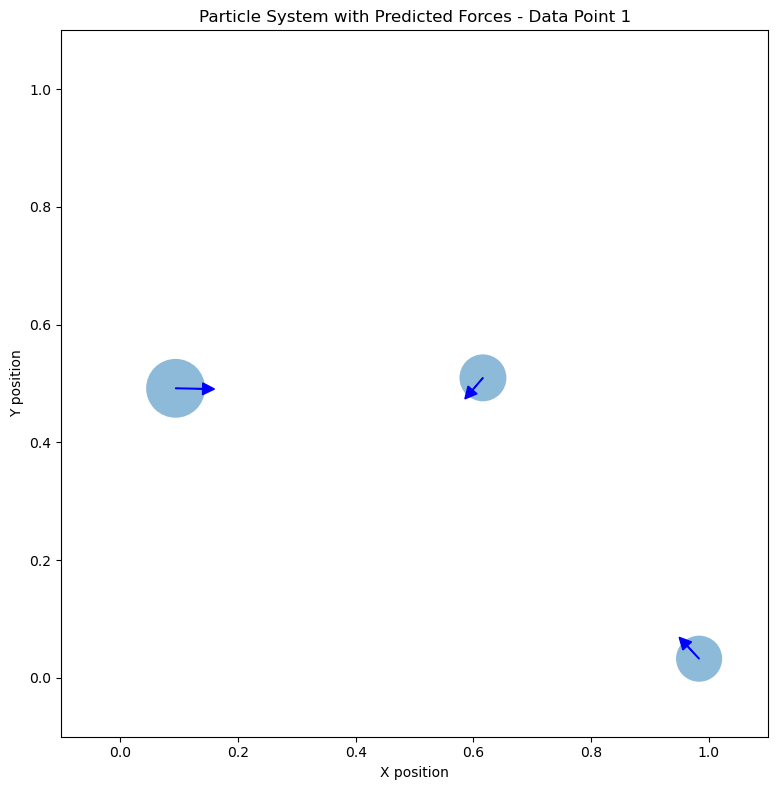

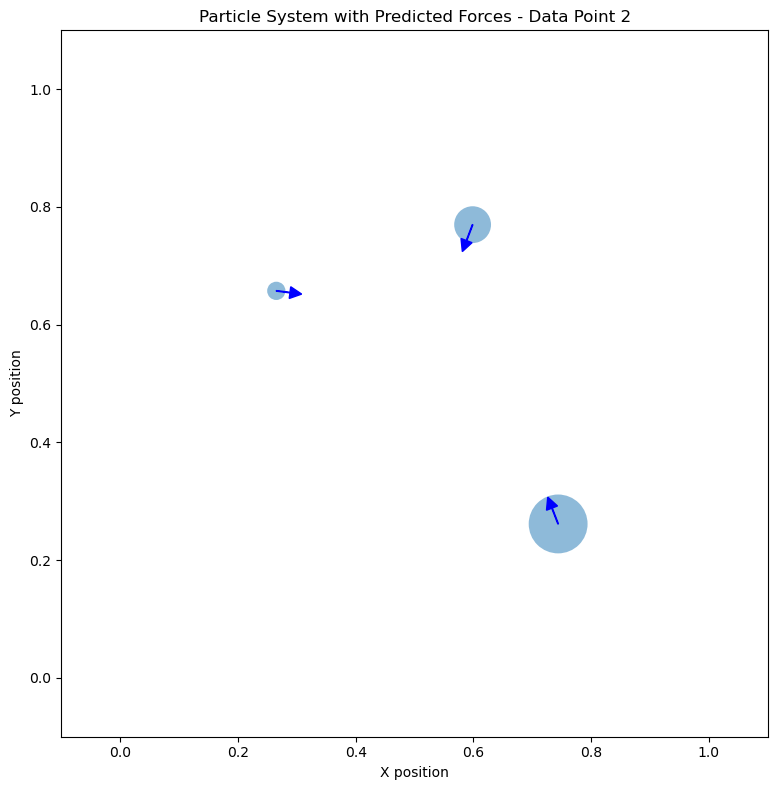

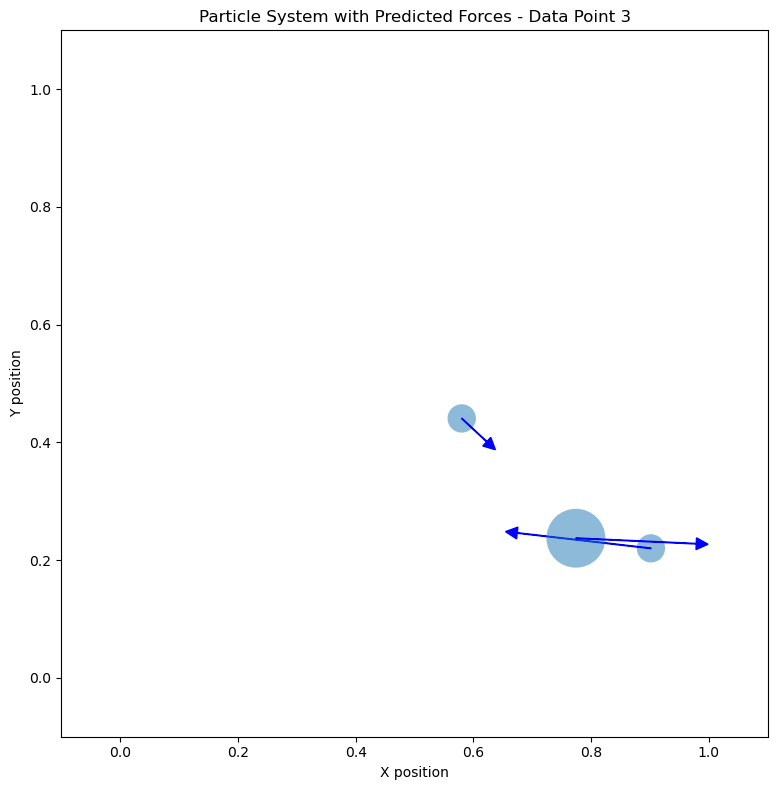

In [34]:
def plot_predicted_forces(data_point, index):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Set plot limits
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    
    # Find the maximum mass for scaling
    max_mass = max(particle[2] for particle in data_point)
    
    # Plot particles and forces
    for particle in data_point:
        x, y, mass, force = particle
        
        # Plot particle as a circle
        radius = (mass / max_mass) / 20  # Scale radius relative to maximum mass
        circle = plt.Circle((x, y), radius=radius, fill=True, alpha=0.5)
        ax.add_artist(circle)
        
        # Plot predicted force arrow
        force_x, force_y = force
        # Scale arrow length
        scale = 0.02
        ax.arrow(x, y, force_x * scale, force_y * scale, 
                 head_width=0.02, head_length=0.02, fc='b', ec='b')
    
    ax.set_aspect('equal')
    ax.set_title(f'Particle System with Predicted Forces - Data Point {index}')
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    
    plt.tight_layout()
    plt.show()

# Plot the predicted forces for the first 3 data points
for i, data_point in enumerate(predicted_particle_dataset[:3]):
    plot_predicted_forces(data_point, i + 1)

In [35]:
print(particle_dataset[0])

[[0.6161157574842869, 0.5096662080339309, 0.6632538980952803, [-1.293101442043127, -1.012958533595781]], [0.9833091568684578, 0.03253713357674759, 0.6511520209952707, [-1.2069166081207372, 1.1922591541375336]], [0.09393729915598126, 0.4918909800469652, 0.8317838195277933, [2.500018050163864, -0.17930062054175283]]]


In [36]:
# Organize the data for PySR

input_data = []
predicted_forces = []
for i, data_point in enumerate(particle_dataset):
    for j in range(0, 3):
        for k in range(0, 3):
            if j != k:
                particleA = data_point[j][:3]
                particleB = data_point[k][:3]
                input_tensor = torch.tensor(particleA + particleB, dtype=torch.float32)
                input_data.append(input_tensor)
                predicted_forces.append(model.edge_model.mlp(input_tensor.cuda()))

# Convert lists to NumPy arrays
input_data = np.vstack(input_data)
predicted_forces = np.vstack([tensor.cpu().detach().numpy() for tensor in predicted_forces])

# Print the first few input data and predicted forces
for i in range(5):
    print(f"Input Data {i + 1}: {input_data[i]}")
    print(f"Predicted Forces {i + 1}: {predicted_forces[i]}")
    print()


Input Data 1: [0.61611575 0.5096662  0.6632539  0.98330915 0.03253713 0.651152  ]
Predicted Forces 1: [1.2272816  0.27217573]

Input Data 2: [0.61611575 0.5096662  0.6632539  0.0939373  0.49189097 0.83178383]
Predicted Forces 2: [-1.0087599  1.0839365]

Input Data 3: [0.98330915 0.03253713 0.651152   0.61611575 0.5096662  0.6632539 ]
Predicted Forces 3: [-0.9024485  -0.11005063]

Input Data 4: [0.98330915 0.03253713 0.651152   0.0939373  0.49189097 0.83178383]
Predicted Forces 4: [-0.00564094  0.03139759]

Input Data 5: [0.0939373  0.49189097 0.83178383 0.61611575 0.5096662  0.6632539 ]
Predicted Forces 5: [ 1.8901113 -1.2327762]



In [37]:
from pysr import PySRRegressor

model = PySRRegressor(
    niterations=40,
    binary_operators=["+", "-","*", "/"],
    unary_operators=["sqrt"],
)

model.fit(input_data, predicted_forces)

/home/polg24/anaconda3/envs/tfg_env/lib/python3.12/site-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
